# Project Part 2

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/CS39AA-project/blob/main/project_part1.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/CS39AA-project/blob/main/project_part1.ipynb)

## 1. Introduction/Background

For my project I will be using a couple different song datasets that contain the song title, the artist, and the genre of the song. I will also be creating my own dataset with my personal spotify data of liked songs. This personal dataset will have the same parameters along with a parameter that will say 1 or 0 if I like the song or do not. All in all, I am using song data to predict if I would like a song based on my own liked songs, and the model will use binary classification to predict if I like the song or not. 

here are links to the datasets I plan to use, one will be used for predictions but I am testing out a few different ones. 

1.  https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset

2. https://www.kaggle.com/datasets/byomokeshsenapati/spotify-song-attributes

3. https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm 

## 2. Exploratory Data Analysis

for part 1 of my project I will be using this dataset: https://www.kaggle.com/datasets/byomokeshsenapati/spotify-song-attributes

In the future I will be using a more refined dataset with more entries, this one has about 4600 so it is a good start for now. 


In [330]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier  # Added this line
from sklearn.metrics import log_loss


Here is the dataset found from kaggle linked above. Here i read it into a file and format it so the only values displayed are trackName, artistName, and genre. Then I add a like column populated with all zeros since these are the songs i will be predicting and they start with not liked. 

In [331]:
song_data = '/kaggle/input/spotify-song-attributes/Spotify_Song_Attributes.csv'
df = pd.read_csv('https://raw.githubusercontent.com/CooperDavis00/CS39AA-Project/main/Spotify_Song_Attributes.csv')
df = df.drop(['msPlayed', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms'], axis=1)
df['like'] = 0
df = df.dropna(subset=['genre'])
df.head()

,trackName,artistName,genre,like
1,"""In The Hall Of The Mountain King"" from Peer G...",London Symphony Orchestra,british orchestra,0
2,#BrooklynBloodPop!,SyKo,glitchcore,0
3,$10,Good Morning,experimental pop,0
4,(I Just) Died In Your Arms,Cutting Crew,album rock,0
5,(L)only Child,salem ilese,alt z,0


Here is my dataset generated from my own spotify playlist with the same columns and i added a like column populated with ones. 


In [332]:
liked_song_data = '/kaggle/input/liked-spotify-songs/liked_songs_with_genre.csv'
df1 = pd.read_csv('https://raw.githubusercontent.com/CooperDavis00/CS39AA-Project/main/liked_songs_with_genre.csv')
df1['like'] = 1
df1.head()

,Track Name,Artist Name(s),Genre,like
0,Gamesofluck,Parcels,"aussietronica, indie soul",1
1,So Much In Love - Armin van Buuren Remix,"D.O.D, Armin van Buuren","electro house, house, pop dance, uk dance, dut...",1
2,Envious - Rezident Remix,"Aluna, Rezident","dance pop, german house",1
3,Change Your Mind,Interupt,bassline,1
4,Isolate,D.O.D,"electro house, house, pop dance, uk dance",1


In [333]:
# Standardizing column names

df1.rename(columns={'Track Name': 'trackName', 'Artist Name(s)': 'artistName', 'Genre': 'genre'}, inplace=True)


print("Columns in df1:", df1.columns)
print("Columns in df:", df.columns)


Columns in df1: Index(['trackName', 'artistName', 'genre', 'like'], dtype='object')
Columns in df: Index(['trackName', 'artistName', 'genre', 'like'], dtype='object')


I am counting the different genres and the amount of times each one is displayed. I then display a graph with the top 15 genres and an other category. 

Summary of Genre Information:
count      9061
unique      893
top       alt z
freq        656
Name: genre, dtype: object


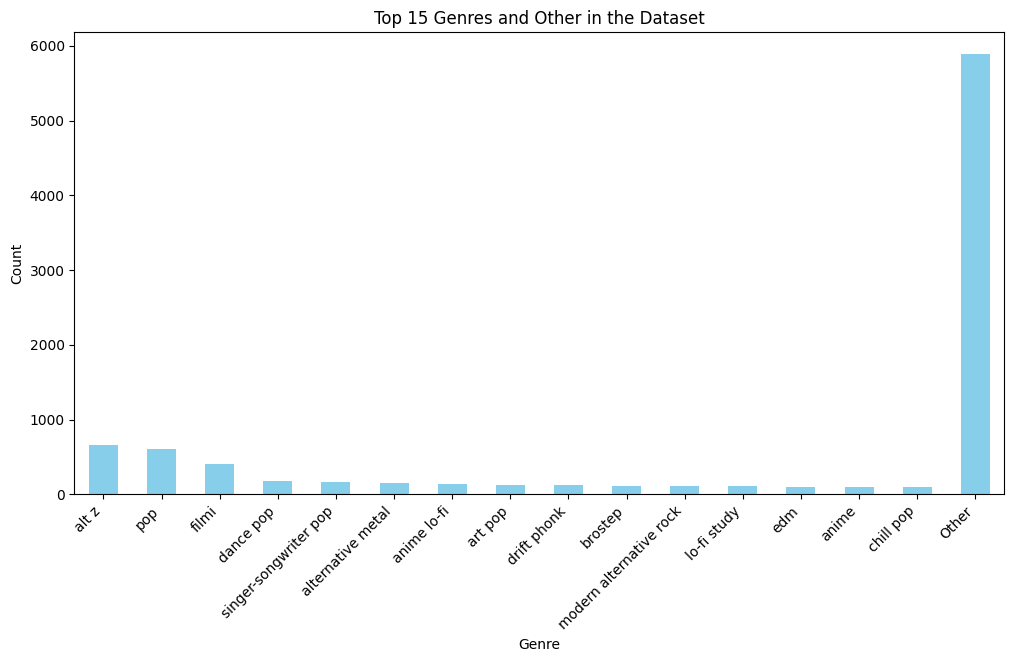

In [334]:
# Concatenate datasets
combined_df = pd.concat([df1, df], ignore_index=True)

# Display the count of each genre in the dataset
genre_counts = combined_df['genre'].value_counts()

genre_description = combined_df['genre'].describe()

print("Summary of Genre Information:")
print(genre_description)

# Keep the top 15 genres, and group the rest as "Other"
top_genres = genre_counts.head(15)
other_genres_count = genre_counts[15:].sum()

# Add "Other" to the top genres
top_genres['Other'] = other_genres_count

# Plot a bar chart
plt.figure(figsize=(12, 6))
top_genres.plot(kind='bar', color='skyblue')
plt.title('Top 15 Genres and Other in the Dataset')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


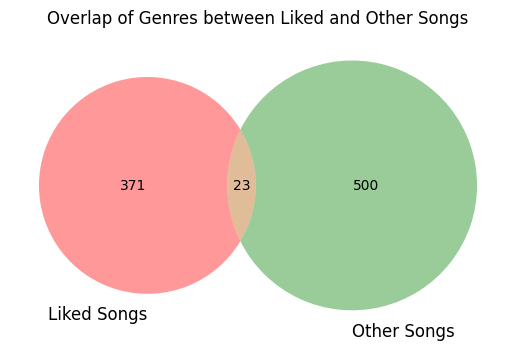

In [335]:
from matplotlib_venn import venn2

# Assuming 'Liked' dataset has a column 'Genre'
liked_genres = set(df1['genre'])
other_genres = set(df['genre'])

# Create a Venn diagram
venn2([liked_genres, other_genres], set_labels=('Liked Songs', 'Other Songs'))
plt.title('Overlap of Genres between Liked and Other Songs')
plt.show()


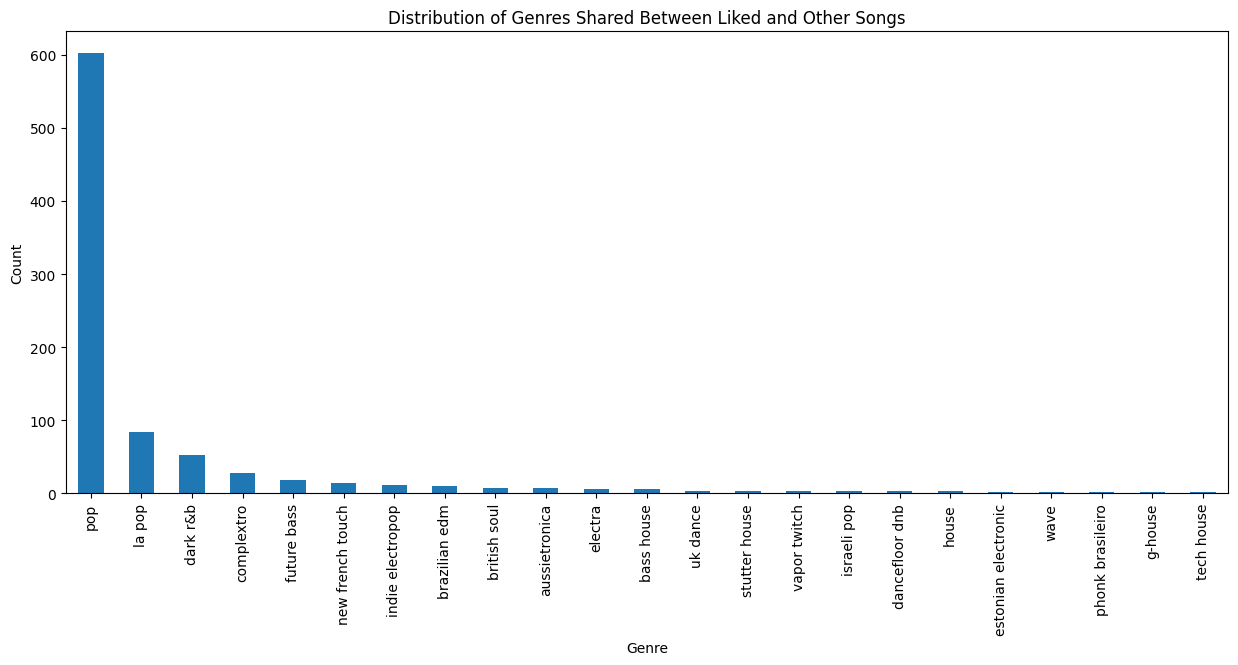

In [336]:
# Find the overlapping genres
overlapping_genres = liked_genres.intersection(other_genres)

# Filter the DataFrame to include only songs with overlapping genres
df_overlapping = df[df['genre'].isin(overlapping_genres)]

# Plot the distribution of genres in the overlapping set
df_overlapping['genre'].value_counts().plot(kind='bar', figsize=(15, 6))
plt.title('Distribution of Genres Shared Between Liked and Other Songs')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()


In this cell i am setting up my variable and training with the logisticRegression model. Then I display the shape and initial accuracy. 


In [337]:
# Assuming 'Genre' is the only feature for simplicity
X = combined_df['genre'].copy()
y = combined_df['like'].copy()

# Split the data into training and testing sets with stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

# Create DataFrame for validation set
df_val = pd.DataFrame({'genre': X_val, 'like': y_val})

# Adding trackName
df_val['trackName'] = combined_df.loc[df_val.index, 'trackName']


# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the training and validation sets
X_train = tfidf_vectorizer.fit_transform(X_train.values.astype('U')).toarray()
X_val = tfidf_vectorizer.transform(X_val.values.astype('U')).toarray()

print(f"X_train.shape = {X_train.shape}")
print(f"X_val.shape = {X_val.shape}")

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training data (liked songs)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
classification_report_str = classification_report(y_val, y_pred)

print(f"Model Accuracy: {accuracy}")
print("Classification Report:\n", classification_report_str)

X_train.shape = (7291, 451)
X_val.shape = (1823, 451)
Model Accuracy: 0.965990126165661
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1716
           1       0.84      0.52      0.64       107

    accuracy                           0.97      1823
   macro avg       0.90      0.76      0.81      1823
weighted avg       0.96      0.97      0.96      1823



testing the accuracy of the model. 

accuracy (on y_train): 0.9697


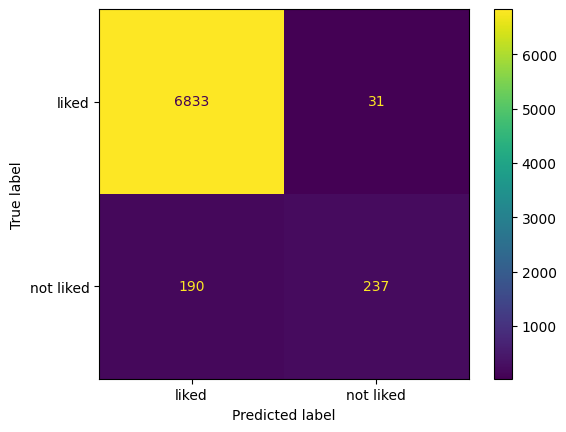

In [338]:
model = LogisticRegression()
model = model.fit(X_train, y_train)

predictions_train = model.predict(X_train)

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train), display_labels=['liked', 'not liked'])
disp.plot()
print(f"accuracy (on y_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on y_val): 0.9660


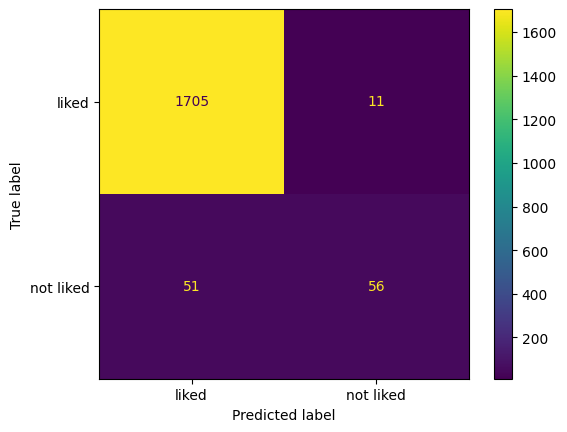

In [339]:
predictions_val = model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['liked', 'not liked'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y_val, predictions_val):.4f}")

In [340]:
# Cell 11: Hyperparameter Tuning
from sklearn.preprocessing import StandardScaler

# Ask the user to input hyperparameter values
hyperparameter_1 = float(input(f"Enter the value for hyperparameter 1 (regularization strength, suggested range: 0.001 to 1000): "))
hyperparameter_2 = int(input(f"Enter the value for hyperparameter 2 (maximum iterations, suggested values: 200, 500, 1000, etc.): "))

# Create a logistic regression model with user-defined hyperparameters
tuned_model = LogisticRegression(C=hyperparameter_1, max_iter=hyperparameter_2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the model on the scaled training data (liked songs)
tuned_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled validation data
y_pred_tuned = tuned_model.predict(X_val_scaled)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_val, y_pred_tuned)
classification_report_str_tuned = classification_report(y_val, y_pred_tuned)

print(f"Tuned Model Accuracy: {accuracy_tuned:.4f}")
print("Classification Report (Tuned Model):\n", classification_report_str_tuned)


Enter the value for hyperparameter 1 (regularization strength, suggested range: 0.001 to 1000):  1
Enter the value for hyperparameter 2 (maximum iterations, suggested values: 200, 500, 1000, etc.):  250


Tuned Model Accuracy: 0.9764
Classification Report (Tuned Model):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1716
           1       0.88      0.69      0.77       107

    accuracy                           0.98      1823
   macro avg       0.93      0.84      0.88      1823
weighted avg       0.98      0.98      0.98      1823



Tune the model by trying different hyperparam values? ['Y'/'N'] Y


   Regularization_Strength  Validation_Loss  Validation_Accuracy
0                    0.001         0.220717             0.941306
1                    0.005         0.210841             0.941306
2                    0.010         0.200063             0.941306
3                    0.050         0.156286             0.942403
4                    0.100         0.137491             0.953922
5                    0.500         0.107530             0.963247
6                    1.000         0.099606             0.965990


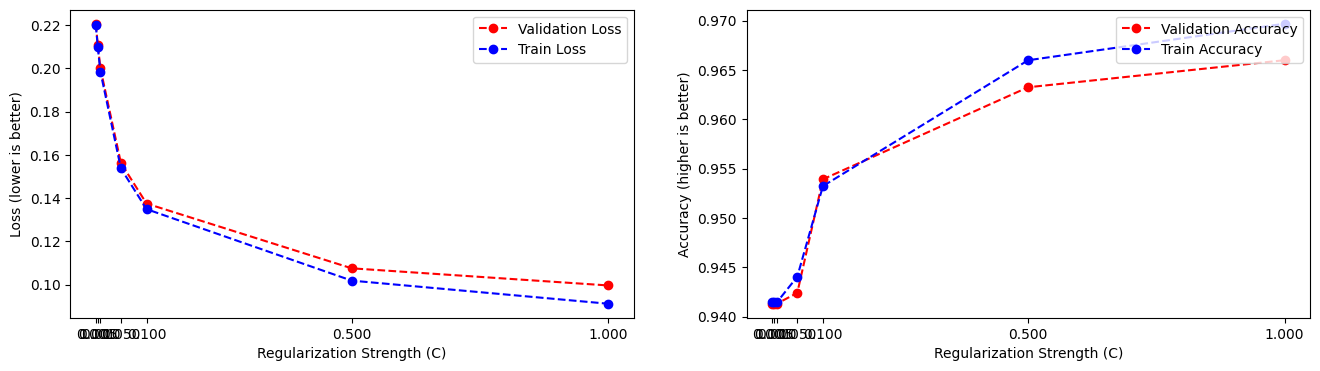

In [351]:
# Ask the user whether to tune the model
use_tuning = input("Tune the model by trying different hyperparam values? ['Y'/'N']")
tune_model = True if use_tuning == 'Y' else False

# A function to create and fit a logistic regression model with a specific hyperparameter value
def tuneModel(hyperparam_value):
    model = LogisticRegression(C=hyperparam_value, random_state=42, max_iter = 1000)
    model.fit(X_train, y_train)
    
    y_train_pred_prob = model.predict_proba(X_train)
    y_train_pred = model.predict(X_train)
    
    y_val_pred_prob = model.predict_proba(X_val)
    y_val_pred = model.predict(X_val)
    
    train_loss = log_loss(y_train, y_train_pred_prob, labels=[0, 1])
    train_acc = accuracy_score(y_train, y_train_pred)
    
    val_loss = log_loss(y_val, y_val_pred_prob, labels=[0, 1])
    val_acc = accuracy_score(y_val, y_val_pred)
    
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter (e.g., regularization strength)
hyp_param_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]  # Example hyperparameter values
metrics = []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))

# Plot the results of the model performance for each hyperparameter value
if tune_model:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="Regularization Strength (C)", ylabel="Loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro')  # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo')  # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="Regularization Strength (C)", ylabel="Accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro')  # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo')  # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=1)

# Display tuning results
if tune_model:
    tuning_results = np.array([hyp_param_vals, [round(metric[1], 2) for metric in metrics], [round(metric[3], 2) for metric in metrics]])
    df_tuning_results = pd.DataFrame({'Regularization_Strength': hyp_param_vals, 'Validation_Loss': [metric[1] for metric in metrics], 'Validation_Accuracy': [metric[3] for metric in metrics]})
    print(df_tuning_results)
